# Rapport interactif

### Sommaire
I. Implémentation sur notre dataset

II. Cas de tests

### Rappel du sujet

Nous essayerons de répondre à la problématique: 
- **Quel est ce monument parisien ?**

À partir de notre dataset.


### Dataset

Nous avons utilisés une extension Chrome qui récupère entre 400 et 500 images à partir d'une recherche, puis nous avons nettoyés certaines images incohérentes. 


### Librairie

Nous avons réalisé **ML**, notre propre librairie de machine learning en C++. Elle dépend de la bibliothèque **Eigen**, qui nous sert à réaliser plus facilement des calculs matriciels.

### Application web

Nous avons décidé de réaliser notre application web en Python en utilisant le micro-framework **Flask** ainsi que **Bootstrap** et **JQuery**

### Étapes de développement

1. Implémentation du perceptron
2. Interopérabilité du perceptron
3. Implémentation du perceptron multi-couches
4. Interopérabilité du perceptron multi-couches
5. Validation sur les cas de tests et correction de la librairie
6. Rédaction de la première version du rapport pour l'étape n°2
7. Création du site web
8. Ajout des fonctionnalités save et load sur le percepetron
9. Interopérabilité du save et du load sur le perceptron
10. Ajout des fonctionnalités save et load sur le perceptron multi-couches
11. Interopérabilité du save et du load sur le perceptron multi-couches
12. Amélioration et finition du site web (*en cours*)
13. Implémentation du Radial Basis Function Network (*en cours*)
14. Rédaction du rapport interactif (*en cours*)
15. Interopérabilité du Radial Basis Function Network (*à venir*)

### Difficultés rencontrées

- Problème d’initialisation des valeurs aléatoires, on avait des modèles tous identiques.
- Tentative d’utiliser std::random_device pour obtenir des valeurs aléatoires plus uniformes. Cela fonctionnait mais on s’est rendus compte que rand() de stdlib suffisait pour notre besoin.
- Confusions due au biais (on a tenté de le supprimer plusieurs fois)
- Erreur d’allocation de mémoire entraînant des erreurs lors du passages des objets par l'interopérabilité
- Destruction d'une instance d'un perceptron multi-couches, mal paramétré entraînant des erreurs lors de l’utilisation de l'interopérabilité.
- Prise en main de NumPy.

# Partie 1. Implémentation sur notre dataset

Dans cette partie, nous montrerons l'étape de pré-traitement des données (*data preprocessing*), puis nous appliquerons notre modéle linéaire ainsi que notre perceptron multi-couches à notre dataset.

## a) Importer le dataset

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from ml import *

In [3]:
IMG_SIZE = (64, 64)
PATH = os.path.join("data_large/")
TRAIN = os.path.join(PATH, "train")
classes = os.listdir(TRAIN)

In [4]:
print(f"Les différentes classes possibles sont: {', '.join(classes)}")

Les différentes classes possibles sont: moulin-rouge, palais-de-l-elysee, pont-neuf, place-de-la-concorde, jardin-des-tuileries, hotel-de-ville, arc-de-triomphe, musee-d-orsay


In [5]:
def import_images_and_assign_labels(folder, label, X, Y, IMG_SIZE=IMG_SIZE):
    """
    Convertit et redimensionne les images d'un dossier en NumPy Array.
    """
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        im = Image.open(image_path)
        im = im.resize(IMG_SIZE)
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (IMG_SIZE[0]* IMG_SIZE[1] * 3,))
        X.append(im_arr)
        Y.append(label)

In [6]:
for s in ["train", "valid", "test"]:
    if s == "test":
        print(f"Nombre d'images dans le {s} set:")
        print(f"{len(os.listdir(os.path.join(PATH, s)))}")
    else:
        print(f"Nombre d'images par classes dans le {s} set:")
        for cl in classes:
            print(f"- {cl}: {len(os.listdir(os.path.join(PATH, s, cl)))}")
        print()

Nombre d'images par classes dans le train set:
- moulin-rouge: 391
- palais-de-l-elysee: 441
- pont-neuf: 487
- place-de-la-concorde: 457
- jardin-des-tuileries: 393
- hotel-de-ville: 359
- arc-de-triomphe: 471
- musee-d-orsay: 418

Nombre d'images par classes dans le valid set:
- moulin-rouge: 129
- palais-de-l-elysee: 129
- pont-neuf: 129
- place-de-la-concorde: 129
- jardin-des-tuileries: 129
- hotel-de-ville: 129
- arc-de-triomphe: 129
- musee-d-orsay: 129

Nombre d'images dans le test set:
1041


In [7]:
def import_dataset(IMG_SIZE=IMG_SIZE):
    """
    Crée les datasets d'entrainement et de validation
    """
    X_train, y_train, X_valid, y_valid = [], [], [], []
    labels = np.identity(len(os.listdir(TRAIN)))        
    for set_type in ["train", "valid"]:
        for cl, lab in zip(classes, labels):
            if set_type == "train":
                X_set, y_set = X_train, y_train
            else:
                X_set, y_set = X_valid, y_valid
            import_images_and_assign_labels(
                os.path.join(PATH, set_type, cl),
                lab,
                X_set,
                y_set,
                IMG_SIZE
            )                
    
    return (np.array(X_train) / 255.0, np.array(y_train)), \
           (np.array(X_valid) / 255.0, np.array(y_valid))

In [8]:
(X_train, y_train), (X_valid, y_valid) = import_dataset()

In [9]:
def showImg(tensor, label, prediction):
    """
    Affiche une image avec sa prediction et label
    """
    fig, ax = plt.subplots()
    ax.imshow(tensor.reshape((IMG_SIZE[0], IMG_SIZE[1], 3)))
    ax.set_title(f'Label: {classes[np.argmax(label)]}')
    ax.set_xlabel(f'Prediction: {np.argmax(prediction)} / Expected output: {np.argmax(label)}')
    ax.set_xticks([])
    ax.set_yticks([]);
    return ax

## b) Appliquer le modéle linéaire au dataset

In [27]:
input_dim = len(X_train[0])

In [28]:
p_model = create_linear_model(input_dim)

In [29]:
picture_test_linear = np.random.randint(0, len(X_train))
test_before = predict_linear_model_classif(p_model, input_dim, X_train[picture_test_linear])
print("Before training:", test_before)

Before training: -1.0


In [30]:
train_linear_classification_model(p_model, input_dim, X_train, y_train.flatten())

In [31]:
test_after = predict_linear_model_classif(p_model, input_dim, X_train[picture_test])
print("After training:", test_after)

After training: -1.0


In [32]:
destroy_linear_model(p_model)

## c) Appliquer le PMC au dataset

In [10]:
NUM_CLASSES = 8

In [11]:
input_dim = [len(X_train[0]), 32, NUM_CLASSES]

In [16]:
p_model, len_output_layer = create_mlp_model(input_dim)

In [17]:
def accuracy(model):
    """
    
    """
    true_preds = 0
    total_preds = len(X_train)
    for x, y in zip(X_train, y_train):
        if np.argmax(predict_mlp_model_classification(model, x, len_output_layer)) == np.argmax(y):
            true_preds += 1
    print(f"Accuracy training: {round((true_preds / total_preds) * 100, 2)}%")
    
    true_preds = 0
    total_preds = len(X_valid)
    for x, y in zip(X_valid, y_valid):
        if np.argmax(predict_mlp_model_classification(model, x, len_output_layer)) == np.argmax(y):
            true_preds += 1
    print(f"Accuracy valid: {round((true_preds / total_preds) * 100, 2)}%")

In [19]:
test_before = predict_mlp_model_classification(p_model, X_valid[picture_test], len_output_layer)
print("Before training:", test_before)

Before training: [0.9999815, -0.99973845, -0.99952537, 0.8999741, -0.8593494, -0.9972533, 0.84355825, 1.0]


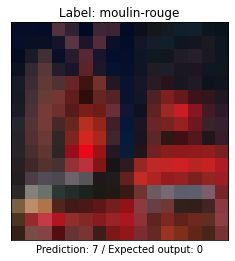

In [20]:
showImg(X_valid[picture_test], y_valid[picture_test], test_before);

In [21]:
random_idx_train = [np.random.randint(0, len(X_train) - 1) for _ in range(50)]
random_idx_valid = [np.random.randint(0, len(X_valid) - 1) for _ in range(50)]

In [22]:
print(len(X_train), len(y_train))
print(len(X_valid), len(y_valid))

print(random_idx_train)
print(random_idx_valid)

3417 3417
1032 1032
[1431, 126, 3068, 300, 1556, 3405, 390, 341, 1395, 949, 2001, 1406, 781, 502, 767, 223, 3302, 1840, 2639, 45, 2828, 1776, 1842, 2293, 1927, 1836, 968, 517, 1226, 2653, 1558, 1828, 295, 79, 3014, 3018, 1948, 1472, 812, 23, 1008, 691, 144, 2496, 2765, 2, 914, 2730, 2718, 3188]
[241, 298, 242, 912, 751, 127, 282, 977, 62, 919, 392, 795, 629, 571, 394, 64, 272, 597, 1007, 756, 205, 159, 67, 396, 429, 192, 154, 832, 902, 1026, 223, 882, 224, 747, 186, 338, 143, 592, 741, 232, 28, 309, 988, 180, 917, 804, 165, 893, 749, 521]


In [23]:
accuracy(p_model)

Accuracy training: 10.77%
Accuracy valid: 10.66%


In [24]:
#accuracy(X_valid[random_idx_valid, :], y_valid[random_idx_valid, :])

In [25]:
train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X_train, y_train.flatten(), epochs=1000)#, alpha=0.01)

In [26]:
save_mlp_model(p_model, "mlp_10000_768_128.txt")

In [27]:
destroy_mlp_model(p_model)

In [31]:
p_model2 = load_mlp_model("mlp_10000_768_128.txt")

LETS GO


In [32]:
input_dim[-1]
print(X_valid[picture_test])
print(p_model2)

[0.21568627 0.35686275 0.56862745 0.23137255 0.36862745 0.58039216
 0.24313725 0.38039216 0.59215686 0.25490196 0.39215686 0.60784314
 0.2627451  0.4        0.61960784 0.26666667 0.40392157 0.62352941
 0.27058824 0.40784314 0.62745098 0.27058824 0.41176471 0.63921569
 0.27058824 0.41568627 0.64313725 0.28235294 0.41960784 0.62745098
 0.27058824 0.41568627 0.61568627 0.2627451  0.40784314 0.61568627
 0.2745098  0.41176471 0.62352941 0.26666667 0.4        0.61176471
 0.30196078 0.41568627 0.59607843 0.4745098  0.51764706 0.6
 0.24313725 0.38431373 0.58431373 0.25490196 0.39215686 0.6
 0.26666667 0.40392157 0.61568627 0.27058824 0.41176471 0.63137255
 0.27843137 0.41960784 0.63921569 0.28235294 0.42352941 0.65098039
 0.28627451 0.43529412 0.65882353 0.32156863 0.44705882 0.63921569
 0.38823529 0.45490196 0.55294118 0.4745098  0.45882353 0.45490196
 0.34117647 0.41960784 0.54901961 0.29019608 0.42352941 0.64313725
 0.29803922 0.42745098 0.63137255 0.28627451 0.41568627 0.62352941
 0.278431

In [ ]:
test_after = predict_mlp_model_classification(p_model2, X_valid[picture_test], input_dim[-1])

In [22]:
print("After training:", test_after)
print("Class index : ", np.argmax(test_after))
print("Class expected :", np.argmax(y_train[picture_test]))

NameError: name 'test_after' is not defined

In [18]:
#showImg(X_valid[picture_test], y_valid[picture_test], test_after);

In [ ]:
accuracy(p_model2)

In [ ]:
destroy_mlp_model(p_model2)

## Part IV. Discover new MLP architectures

In [10]:
import random

In [11]:
number_of_hidden_layers = [0, 1, 2, 3]
hidden_layers = [8, 16, 32]
size_img = [(8, 8), (16, 16), (32, 32)]
EPOCHS = [100000, 150000, 200000]

In [12]:
def accuracy_grid_search(model, len_output, X_tr, y_tr, X_val, y_val):
    train_total, valid_total = len(X_train), len(X_valid)
    true_preds = 0
    total_preds = len(X_tr)
    for x, y in zip(X_tr, y_tr):
        if np.argmax(predict_mlp_model_classification(model, x, len_output)) == np.argmax(y):
            true_preds += 1
    train_acc = round((true_preds / total_preds) * 100, 2)
    
    true_preds = 0
    total_preds = len(X_val)
    for x, y in zip(X_val, y_val):
        if np.argmax(predict_mlp_model_classification(model, x, len_output)) == np.argmax(y):
            true_preds += 1
    valid_acc = round((true_preds / total_preds) * 100, 2)
    
    return train_acc, valid_acc

In [ ]:
max_train_acc, max_val_acc = 0.0, 0.0

for ep in EPOCHS:
    for s in size_img:
        IMG_SIZE = s
        (X_train, y_train), (X_valid, y_valid) = import_dataset(IMG_SIZE=IMG_SIZE)
        input_dim = [len(X_train[0])]
        for n, num_h in enumerate(number_of_hidden_layers):
            h = random.choices(hidden_layers, k=num_h)
            if h:
                input_dim.extend(random.choices(hidden_layers, k=num_h))
            input_dim.append(8)

            model, last_output_layer = create_mlp_model(input_dim)
            train_classification_stochastic_gradient_backpropagation_mlp_model(model, X_train, y_train.flatten(), epochs=ep)

            train_acc, valid_acc = accuracy_grid_search(model, last_output_layer, X_train, y_train, X_valid, y_valid)

            if input_dim[1:-1] == []:
                filename = f"models/mlp/MLP_{ep}_{IMG_SIZE[0]}x{IMG_SIZE[1]}_{input_dim[-1]}_t_acc-{train_acc}_v_acc-{valid_acc}.txt"
            else:
                filename = f"models/mlp/MLP_{ep}_{IMG_SIZE[0]}x{IMG_SIZE[1]}_{'_'.join(map(str, input_dim[1:]))}_t_acc-{train_acc}_v_acc-{valid_acc}.txt"

            print(f"Model parameters: epochs={ep}, img_size={IMG_SIZE}, input_dim={input_dim[1:]} -- Train acc: {train_acc}% / Valid_acc: {valid_acc}%")

            if train_acc > max_train_acc:
                max_train_acc = train_acc
                save_mlp_model(model, filename)
            if valid_acc > max_val_acc:
                max_val_acc = valid_acc
                save_mlp_model(model, filename)

            destroy_mlp_model(model)

            input_dim = [len(X_train[0])]

    print(f"Max Train acc: {max_train_acc}% / Max Valid_acc: {max_val_acc}%")


Model parameters: epochs=20000, img_size=(8, 8), input_dim=[8] -- Train acc: 13.81% / Valid_acc: 14.53%
Model parameters: epochs=20000, img_size=(8, 8), input_dim=[16, 8] -- Train acc: 13.37% / Valid_acc: 12.5%
Model parameters: epochs=20000, img_size=(8, 8), input_dim=[16, 64, 8] -- Train acc: 12.29% / Valid_acc: 13.76%
Model parameters: epochs=20000, img_size=(8, 8), input_dim=[32, 64, 64, 8] -- Train acc: 15.83% / Valid_acc: 15.12%
Model parameters: epochs=20000, img_size=(8, 8), input_dim=[32, 64, 32, 16, 8] -- Train acc: 15.42% / Valid_acc: 13.66%
Model parameters: epochs=20000, img_size=(16, 16), input_dim=[8] -- Train acc: 17.27% / Valid_acc: 17.64%
Model parameters: epochs=20000, img_size=(16, 16), input_dim=[16, 8] -- Train acc: 10.51% / Valid_acc: 12.5%
Model parameters: epochs=20000, img_size=(16, 16), input_dim=[16, 16, 8] -- Train acc: 13.61% / Valid_acc: 13.47%
Model parameters: epochs=20000, img_size=(16, 16), input_dim=[32, 64, 32, 8] -- Train acc: 15.1% / Valid_acc: 12